# **EMOTIONS RECOGNITION THROUGH CNN MODEL**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import random
from PIL import Image
import io
from google.colab import drive
drive.mount('/content/gdrive')
import torch
from seaborn import heatmap 
from mlxtend.plotting import plot_confusion_matrix as plm

from sklearn.model_selection import train_test_split
#from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
os.chdir("/content/gdrive/My Drive")

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/formattazione/python/projet/kaggle/fer2013.csv')

The first operation required is to extract from the dataset the pictures, this
require a little bit of intuition about how they are stored inside the dataset. 
The pictures are saved as a singular vector, so we need to separated each point inside the vector and than create several different smaller vectors, whose each
of them contain a singular picture

In [ ]:
datapoints = data['pixels'].tolist()

def extract_array(datapoints,width,height):
    X = []
    for xseq in datapoints:
        xx = [int(xp) for xp in xseq.split(' ')] 
        xx = np.asarray(xx).reshape(width, height)
        X.append(xx.astype('float32')) 
    X = np.asarray(X)
    X = np.expand_dims(X, -1)
    return X

x = extract_array(datapoints,48,48)

We now can extract from the data the different emoctions and create a list that specify what emotions we will predict

In [ ]:
y = pd.get_dummies(data['emotion']).as_matrix()
labels = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


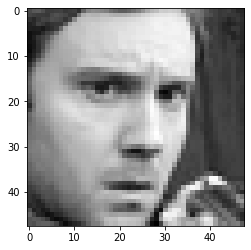

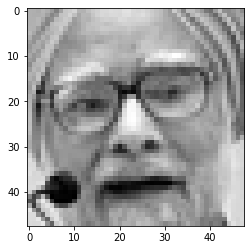

In [ ]:
def plot_image(array,number):
    dim1 = len(array[1])
    dim2 = len(array[2])
    for image in range(number):
        plt.imshow(array[image].reshape(dim1,dim2), interpolation='none', cmap='gray')
        plt.show()

plot_image(x,2)

We can now try to use some descriptive statistic in order to analize the dataset:

,frequencies,percetual
Angry,4953,14.0
Disgust,547,2.0
Fear,5121,14.0
Happy,8989,25.0
Sad,6077,17.0
Surprise,4002,11.0
Neutral,6198,17.0


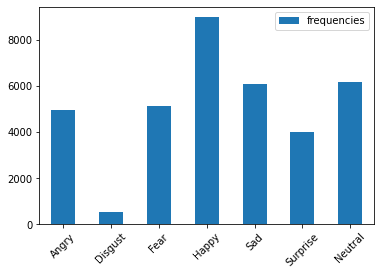

In [ ]:
def summary_labels(y):
    li = len(y)
    frequencies = []
    perc = []
    for col in range(len(y[0])):
        freq_col =np.sum(y[:,col])
        frequencies.append(freq_col)
    for freq in range(len(frequencies)):
        percvalue = round((frequencies[freq] / li) * 100)
        perc.append(percvalue)
    df = pd.DataFrame(data=list(zip(frequencies,perc)),index=(labels),columns=['frequencies','percetual'])
    df.plot.bar(y = 'frequencies', rot=45)
    return df

summary_labels(y)

These easy analysis show how the dataset is not simmetric, therefore the CNN would be very good predict happiness or sadness but not that good for disgust.
Let's print out the dimension of the pictures, the numbers of labels and the number of different pictures, these informations will come useful soon. 

In [ ]:
print("Image size:  "+str(len(x[0])))
print("Number of Labels:  "+ str(len(y[0])))
print("Number of examples in dataset:  "+str(len(x)))

Image size:  48
Number of Labels:  7
Number of examples in dataset:  35887


Let's now set some parameters for the CNN. We set 32 as number of filters, this number rapresent the number of filters that the CNN will use in the starting convolutional. We set the number of labels ( number of emotions) this will become useful in order to link the last layer, bacause we want the output of the CNN equal to the different emotions. We set the batch size equal to 128, this value comes after a phase of tuning of the parameters. The batch size indicate the numbers of elements pass through the neural network at the same time. The last parameter is the epochs, setted equal to 80, to be sure to obtain good results.  

In [ ]:
num_features = 32
num_labels = 7
batch_size = 128 

Let's standardize the pictures and let's create the train, the validation and test sets

In [ ]:
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)


We are now ready to create the architecture of the CNN:

In [ ]:
def create_model():
  model = Sequential()


  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1))) 
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization()) 
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))
  
  model.add(Flatten())
  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(num_labels, activation='softmax'))
  model.compile(loss=categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])
  return model


Let's print the architecture of the CNN:
 
 

In [ ]:
plot_model(create_model(), show_shapes= True, show_layer_names= False  )  

Before the initialitation of the model, let's introduce a callback method, useful for the optimitation. Each epoch, if the value of validation accuracy is the minimum, the function saves the value and allow to call later, in order to assure the best valutation.

In [ ]:
filepath="/content/gdrive/My Drive/formattazione/python/projet/epochs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [ ]:
n_split=5

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 
#x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1, random_state=42) 

for train_index,validation_index in KFold(n_split).split(x_train):
  x_train,x_validation=x[train_index],x[validation_index] # create the validation for x
  y_train,y_validation=y[train_index],y[validation_index] # create the validation for y
  model = create_model()                                  # call the model
  fit = model.fit(np.array(x_train), np.array(y_train),   # fit the model with batch size = 128, 100 x 3 epochs , shuffle the xs
         batch_size=batch_size,
         epochs=60,
         validation_data=(np.array(x_validation), np.array(y_validation)),
         shuffle = True,
         callbacks= callbacks_list)
  plt.title('Loss')
  plt.plot(fit.history['loss'], label='train')
  plt.plot(fit.history['val_loss'], label='validation')
  plt.legend()
  plt.show()
  plt.title('Accuracy')
  plt.plot(fit.history['acc'], label='train')
  plt.plot(fit.history['val_acc'], label='validation')
  plt.legend()
  plt.show()

We are now ready to starting the model, using adam as optimizer and categorical cross entropy as loss function, this because the output is a categorical variable. 

In [ ]:
###########################################################################################
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
#
#model.compile(loss=categorical_crossentropy, 
#              optimizer='adam',
#              metrics=['accuracy'])
#
#
#
#fit = model.fit(np.array(x_train), np.array(y_train),
#          batch_size=batch_size,
#          epochs=100,
#          validation_data=0.1,
#          shuffle = True,
#          callbacks= callbacks_list)
###########################################################################################

Before the evalutation on the test sets, let's check out how the loss function
and the accuracy have been behaved:

In [ ]:
############################################################################################
#plt.title('Loss')
#plt.plot(fit.history['loss'], label='train')
#plt.plot(fit.history['val_loss'], label='validation')
#plt.legend()
#plt.show()
############################################################################################

In [ ]:
############################################################################################
#plt.title('Accuracy')
#plt.plot(fit.history['acc'], label='train')
#plt.plot(fit.history['val_acc'], label='validation')
#plt.legend()
#plt.show()
############################################################################################

In [ ]:
evaluation = model.evaluate(x_test,y_test)
evaluation

7178/7178 [==============================] - 2s 250us/step


[0.588228821820886, 0.8622178879578687]

In [ ]:
#10 % k 3 seed 42 epochs 30 = 0.74
#10 % k 5 seed 02 epochs 30 = 0.79
#20 % k 5 seed 42 epochs 30 = 0.78
#10 % k 10 seed 42 epochs 30  = 0.82
#20 % k 5 seed 42 epochs 50 = 0.8482
#20 % k 5 seed 42 epochs 60 = 0.8622

val_loss starts increasing, val_acc starts decreasing. This means model is cramming values not learning

val_loss starts increasing, val_acc also increases.This could be case of overfitting or diverse probability values in cases where softmax is being used in output layer

val_loss starts decreasing, val_acc starts increasing. This is also fine as that means model built is learning and working fine.

In [ ]:
saved_model = load_model('/content/drive/My Drive/formattazione/python/projet/epochs/epochs:046-val_acc:0.646.hdf5')
saved_model.evaluate(x_test, y_test)

7178/7178 [==============================] - 3s 378us/step


[0.5808112748521521, 0.8383950960938397]

In [ ]:
prediction_x = model.predict(x_test)
pred = np.zeros_like(prediction_x)
pred[np.arange(len(prediction_x)), prediction_x.argmax(1)] = 1
pred = pred.astype('uint8')

In [ ]:
list_ind_pred=pred.argmax(axis=1)
list_ind_test= y_test.argmax(axis=1)

In [ ]:
table = pd.crosstab(list_ind_pred,list_ind_test)

In [ ]:
pd.DataFrame(np.asarray(table), columns = labels, index= labels)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,809,7,47,18,61,12,33
Disgust,9,89,1,1,2,1,1
Fear,36,1,833,15,47,47,26
Happy,19,0,16,1656,9,14,33
Sad,66,4,86,30,1015,4,100
Surprise,6,0,27,16,2,708,6
Neutral,40,1,33,29,74,9,1079


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-329-1501de6db402>", line 1, in <module>
    plm(conf_mat= np.asarray(table), show_absolute=False, show_normed=True, colorbar=True)
  File "/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py", line 106, in plot_confusion_matrix
    plt.ylabel('true label')
TypeError: 'list' object is not callable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/pyt

TypeError: ignored

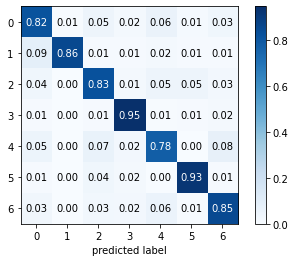

In [ ]:
plm(conf_mat= np.asarray(table), show_absolute=False, show_normed=True, colorbar=True)

In [ ]:
def confront_results(array_test):
    image_index = random.randrange(len(x_test))
    dim1 = len(array_test[1])
    dim2 = len(array_test[2])
    plt.imshow(x[image_index].reshape(48,48), cmap='gray')
    pred = model.predict(array_test[image_index].reshape(1, dim1, dim2, 1)) #saved_model.predict
    print('this is : ', labels[pred.argmax()] )


this is :  Neutral


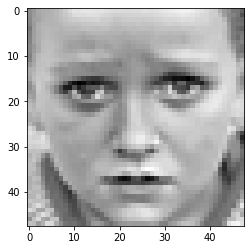

In [ ]:
confront_results(x_test)

this is :  Surprise


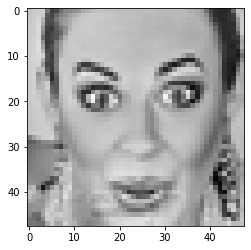

In [ ]:
confront_results(x_test)

Let's try now with some imported pictures how it work:

In [ ]:
def predict_imported_images(pattern):
    dimarray= len(x_test[0])
    img=Image.open(pattern).convert('L')
    imgarray=np.array(img)
    imgarray_resized = resize(imgarray, (dimarray,dimarray))
    img_ready = np.expand_dims(imgarray_resized, 0)
    img_ready = np.expand_dims(img_ready, -1)
    prediction = model.predict(img_ready) #saved_model.predict
    plt.imshow(imgarray, cmap = 'gray')
    print('this is : ', labels[prediction.argmax()] )


In [ ]:
predict_imported_images('#insert here pattern of a picture to make prediction with you own photo')